In [1]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from notebooks import utils
%matplotlib inline

In [2]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:///home/cloudera/Downloads/big-data/daily_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [3]:
df.count()

1095

In [4]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
number,1095,547.0,316.24357700987383,0,1094
air_pressure_9am,1092,918.8825513138094,3.184161180386833,907.9900000000024,929.3200000000012
air_temp_9am,1090,64.93300141287072,11.175514003175877,36.752000000000685,98.90599999999992
avg_wind_direction_9am,1091,142.2355107005759,69.13785928889189,15.500000000000046,343.4
avg_wind_speed_9am,1092,5.50828424225493,4.5528134655317185,0.69345139999974,23.554978199999763
max_wind_direction_9am,1092,148.95351796516923,67.23801294602953,28.89999999999991,312.19999999999993
max_wind_speed_9am,1091,7.019513529175272,5.598209170780958,1.1855782000000479,29.84077959999996
rain_accumulation_9am,1089,0.20307895225211126,1.5939521253574893,0.0,24.01999999999907
rain_duration_9am,1092,294.1080522756142,1598.0787786601481,0.0,17704.0


In [5]:
before = df.count()

In [6]:
df = df.na.drop()

In [7]:
after = df.count()

In [8]:
before - after

31

In [9]:
df.columns

['number',
 'air_pressure_9am',
 'air_temp_9am',
 'avg_wind_direction_9am',
 'avg_wind_speed_9am',
 'max_wind_direction_9am',
 'max_wind_speed_9am',
 'rain_accumulation_9am',
 'rain_duration_9am',
 'relative_humidity_9am',
 'relative_humidity_3pm']

In [10]:
featuresUsed = ['air_pressure_9am', 'air_temp_9am', 'avg_wind_direction_9am', 'avg_wind_speed_9am', 'max_wind_direction_9am', 'max_wind_speed_9am', 'relative_humidity_9am']
assembler = VectorAssembler(inputCols = featuresUsed, outputCol = "features_unscaled")
assembled = assembler.transform(df)

In [11]:
scaler = StandardScaler(inputCol = "features_unscaled", outputCol = "features", withStd = True, withMean = True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [12]:
scaledData = scaledData.select("features", "number")

In [13]:
scaledDataFeat = scaledData.select('features')
scaledDataFeat.persist()

DataFrame[features: vector]

In [14]:
kmeans1 = KMeans(k = 9, seed = 11)
model1 = kmeans1.fit(scaledDataFeat)
transformed1 = model1.transform(scaledDataFeat)

In [15]:
centers1 = model1.clusterCenters()

In [16]:
P1 = utils.pd_centers(featuresUsed, centers1)

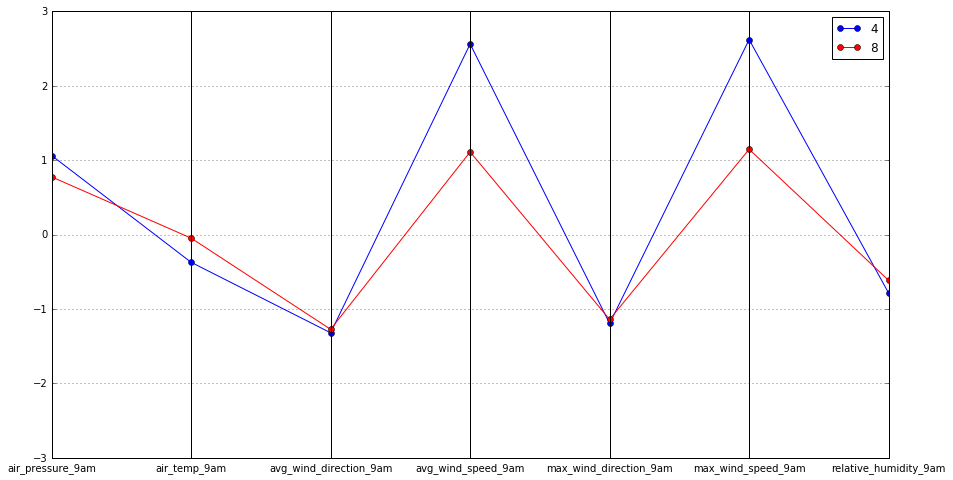

In [17]:
utils.parallel_plot(P1[(P1['relative_humidity_9am'] < 0.5) & (P1['max_wind_speed_9am'] > 0.5)], P1)